In [ ]:
import os 
import glob 
import PIL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import imageio
from skimage import io, color

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as transforms
from torch import nn 
from torchvision.models import vgg16
import torch.optim as optim
device = 'cuda:0'

## Part 1: Classifying  Steel  Surface  Defects

In [ ]:
!wget https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps5/data/neu_surface_defect_jpg.tar.gz
!tar -xf neu_surface_defect_jpg.tar.gz

--2022-04-17 23:27:17--  https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps5/data/neu_surface_defect_jpg.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20738857 (20M) [application/octet-stream]
Saving to: ‘neu_surface_defect_jpg.tar.gz’

neu_surface_defect_ 100%[===================>]  19.78M  --.-KB/s    in 0.06s   

2022-04-17 23:27:17 (340 MB/s) - ‘neu_surface_defect_jpg.tar.gz’ saved [20738857/20738857]



### 1.1 (15 points)  Build Image Datasets and DataLoaders

Get all the image filepaths.

In [ ]:
files = glob.glob(os.path.join('neu_surfae_defect_images', "*.jpg"))

Visualize a random image.

neu_surfae_defect_images/PS_11.jpg


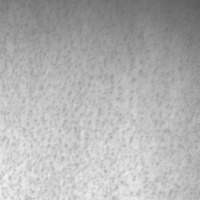

In [ ]:
idx = 30
img = Image.open(files[idx])
print(files[idx])
img

Your ImageDataset class.

In [ ]:
# dictionary labels 
label_dict = {
'Cr': 0, 
'In': 1, 
'Pa': 2,
'PS': 3, 
'RS': 4,
'Sc': 5
}

class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        
        '''
        Image dataset object that loads and transforms images. 
        
        '''
        
        self.paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        #########your implementation here######### 
        
        
        # read images given file path 
        img = Image.open(self.paths[idx]).convert('RGB')

        i = (self.paths[idx]).find("/")
        label = label_dict[self.paths[idx][i+1:i+3]]
        #########your implementation here#########

        # transform images 
        if self.transform:
            img = self.transform(img)
        sample = img, label
        return sample

Transform your dataset, split the data, and define your Datasets and DataLoaders.

In [ ]:
transform = transforms.Compose([
              transforms.Resize((224,224)),
              transforms.ToTensor(),
              transforms.Normalize(
                  mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225]
              )
            ])

dataset = ImageDataset(files, transform)

# Train, validation, test split
X_train, X_test = train_test_split(files, test_size=0.2)
X_train, X_val = train_test_split(X_train, test_size=0.1)

#Build Dataset 
train_data = ImageDataset(X_train, transform)
val_data = ImageDataset(X_val, transform)
test_data = ImageDataset(X_test, transform)

# Build DataLoader 
batch_size = 4
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

### 1.2 (10 points) Understand the Model Architecture

Define and load a pretrained VGG16 model.

In [ ]:
class VGG_fc1(nn.Module):
    def __init__(self, pretrain=True):
        super(VGG_fc1, self).__init__()
        self.features = vgg16(pretrained=pretrain).features # convolutional layers
        self.avgpool = vgg16(pretrained=pretrain).avgpool
        self.fc1 = vgg16(pretrained=pretrain).classifier[0] # first layer of classifier
        
    def forward(self, x):
        """Extract first fully connected feature vector"""
        # Apply convolutions
        x = self.features(x)
        # Apply pooling
        x = self.avgpool(x)
        # Flatten and convert to vectors
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x
    
model = VGG_fc1(pretrain=True).eval() # turn model into evaluation mode
model = model.to('cuda:0')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

The model architecture.

In [ ]:
print(model)

VGG_fc1(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

Choose an image from your training set and visualize 4 channels in each of layers 1, 5, and 10.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


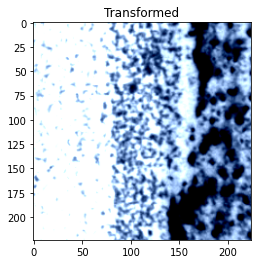

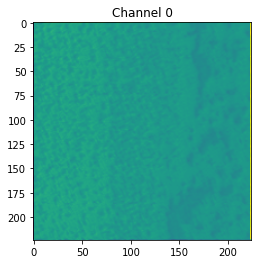

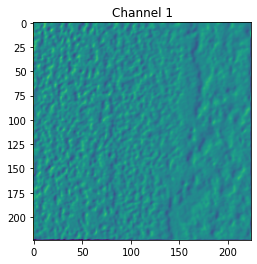

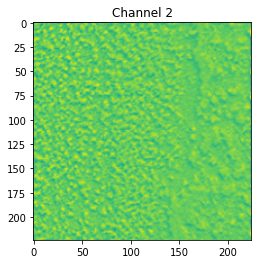

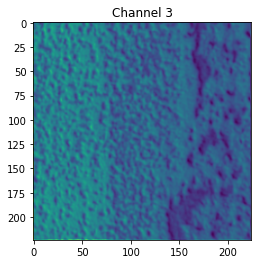

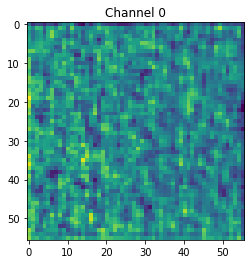

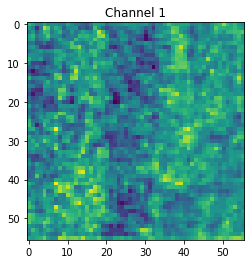

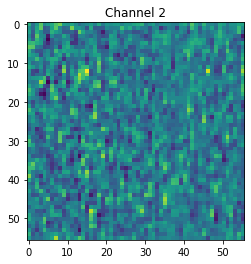

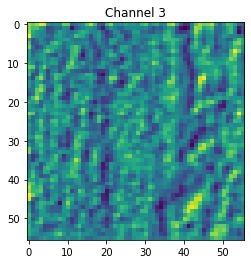

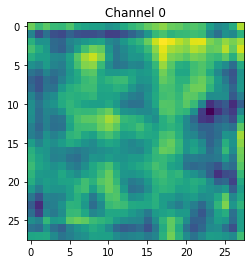

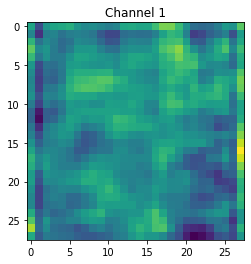

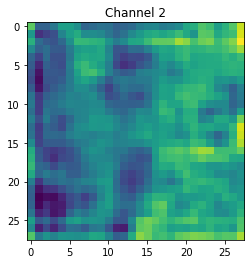

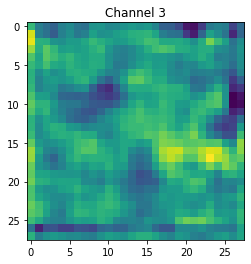

In [ ]:
example_img, label = dataset[0]
inp = example_img.numpy().transpose((1, 2, 0))
print(inp.shape)
plt.imshow(inp)
plt.title("Transformed")
plt.show()

example_img = torch.unsqueeze(example_img, 0).to(device)
convolutions = [0,10,21]


for i, submodule in model.features._modules.items():
  example_img = submodule(example_img)
  
  # after 1, 5, and 10 convolutions
  if int(i) in convolutions:
    temp = torch.squeeze(example_img, 0)

    # randomly visualize 4 channels
    for i in range(4):
      plt.imshow(temp[i].cpu().detach().numpy())
      plt.title(f"Channel {i}")
      plt.show()

What do you observe?

In [ ]:
'''
The image channels get gradually more blurry and pixelated with each convolution. Additionally, there are darker grooves in the transformed image that are highlighted (more smooth) after the convolutions.
Each channel for the same convolution also have slightly different emphases.
'''

### 1.3 (20 points) Train a Classifier with Transfer Learning

Define a VGG-based transfer learning classifier.

In [ ]:
class VGG(nn.Module):
    def __init__(self, pretrain=True):
        super().__init__()
        self.features = vgg16(pretrained=pretrain).features # convolutional layers
        self.avgpool = vgg16(pretrained=pretrain).avgpool
        self.fc1 = vgg16(pretrained=pretrain).classifier[0] # first layer of classifier
        self.classifier = nn.Sequential(
                            nn.Linear(4096, 2048), 
                            nn.ReLU(), 
                            nn.Linear(2048, 6),)
        
    def forward(self, x):
        """Extract first fully connected feature vector"""
        # Apply convolutions
        x = self.features(x)
        # Apply pooling
        x = self.avgpool(x)
        # Flatten and convert to vectors
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.classifier(x)
        return x

Train your classifier.

In [ ]:
new_model = VGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(new_model.classifier.parameters(), lr=1e-3)

In [ ]:
def loop(model, loader, epoch, evaluation=False):
    
    if evaluation:
        model.eval()
        mode = "eval"
    else:
        model.train()
        mode = 'train'
    batch_losses = []
    
    # Define tqdm progress bar 
    tqdm_data = tqdm(loader, position=0, leave=True, desc='{} (epoch #{})'.format(mode, epoch))
    
    for datas in tqdm_data:
        
        data, targets = datas
        data, targets = data.to(device), targets.to(device)
        out = new_model(data)
        loss = criterion(out, targets)
        
        if not evaluation:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        batch_losses.append(loss.item())

        postfix = ['batch loss={:.3f}'.format(loss.item()) , 
                   'avg. loss={:.3f}'.format(np.array(batch_losses).mean())]
        
        tqdm_data.set_postfix_str(' '.join(postfix))
    
    return np.array(batch_losses).mean()



for epoch in range(5):    
    train_loss = loop(new_model, train_loader, epoch)
    val_loss = loop(new_model, val_loader, epoch, evaluation=True)

eval (epoch #4): 100%|██████████| 36/36 [00:01<00:00, 26.77it/s, batch loss=0.000 avg. loss=0.000]


Compute and plot a test confusion matrix.

Test accuracy: 359/360 =  99.722%


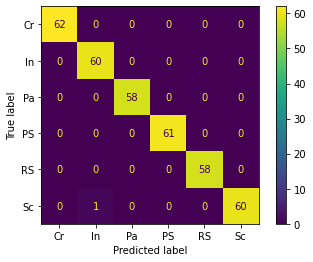

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_predicted = []
all_labels = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_val = new_model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

        all_predicted.extend(predicted.cpu().tolist())
        all_labels.extend(y_test.cpu().tolist())

print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

cm = confusion_matrix(all_labels, all_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_dict.keys()))
disp.plot()
plt.show()

Why do you need to resize images to specific shapes and normalize pixel values to specific values for each color channel?

In [ ]:
'''
The pre-trained model that we use has input specifications regarding size and normalization range, so we have to pre-process our images to fit these specifications.
'''

What are the benefits of transfer learning versus training the entire stack (CNN + MLP) again. What are the potential limitations of this approach? 

In [ ]:
'''
Instead of training a model from scratch, transfer learning allows you to achieve higher accuracy when you have computational limits or insufficient data (ex. medical imaging)
by modifying existing architecture. However, if the initial and target tasks are not similar enough, the transfer learning will not attain high accuracy. Thus, there needs to
be a relation between your dataset and the dataset that trained the pre-trained model. Additionally, one must be cautious of overfitting the model during transfer learning if you
don't have lots of training data because the typical pre-trained model has millions of parameters.

'''

### 1.4 (15 points) Obtain Saliency Maps

Compute the saliency map for two images of each class.


In [ ]:
# Get two images from each defect class

images = {x:[] for x in label_dict.keys()}

for i in range(len(dataset)):
  img, label = dataset[i]
  label_ = [key for key, val in label_dict.items() if val==label][0]

  if len(images[label_]) < 2:
    images[label_].append(img)
  
  if len(images.values()) == 8:
    break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


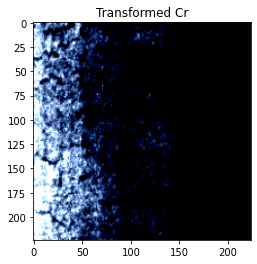

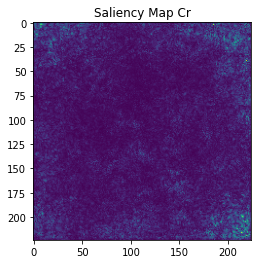

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


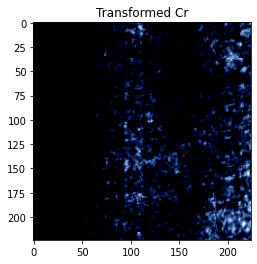

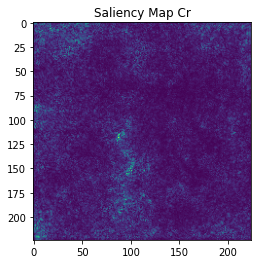

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


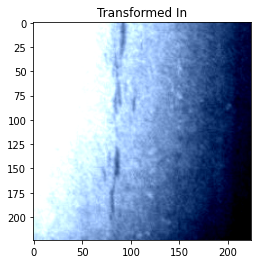

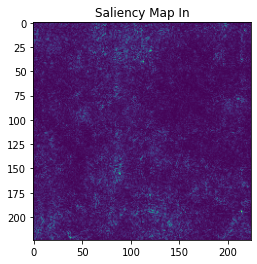

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


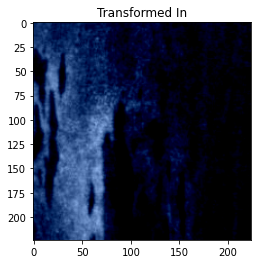

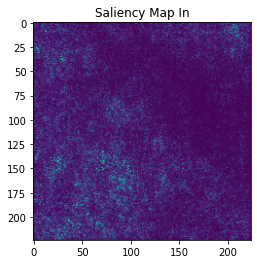

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


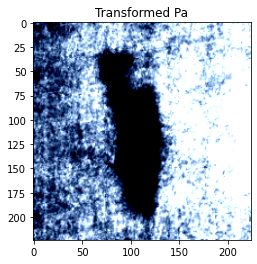

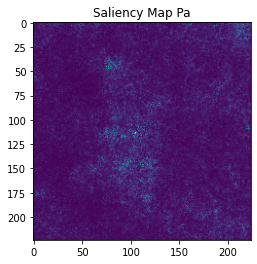

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


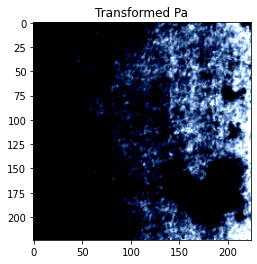

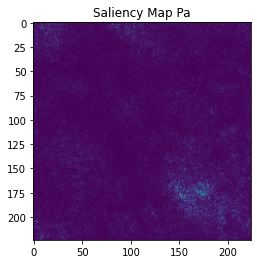

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


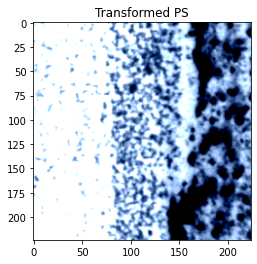

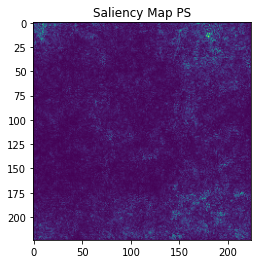

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


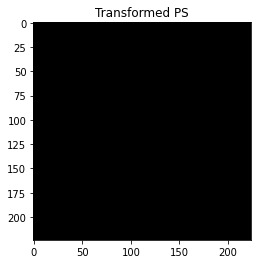

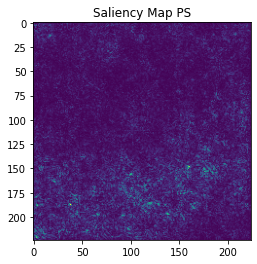

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


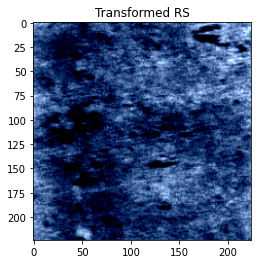

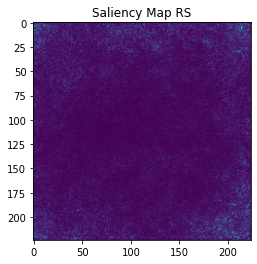

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


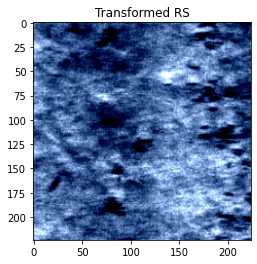

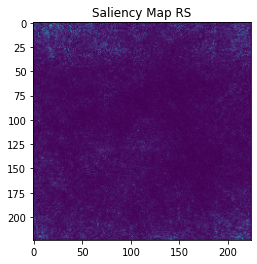

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


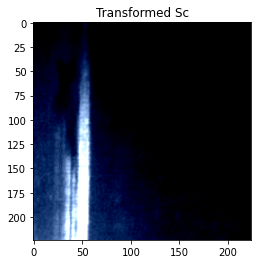

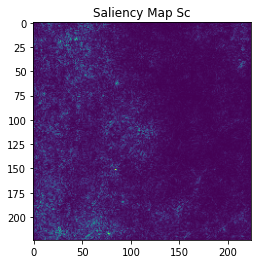

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


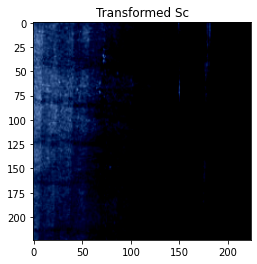

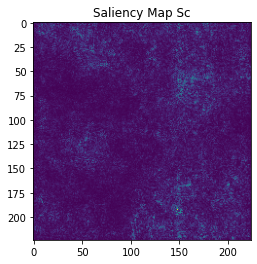

In [ ]:
for label, image_list in images.items():
  for x in image_list:

    inp = x.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    plt.title(f"Transformed {label}")
    plt.show()

    x = torch.unsqueeze(x, 0).to(device)
    x.requires_grad = True
    y = new_model(x).max()
    y.backward()

    gradient = x.grad.data
    _gradient = abs(gradient[0].cpu().detach().numpy())
    mean_grad = np.mean(_gradient, axis=0)
    
    plt.imshow(mean_grad)
    plt.title(f"Saliency Map {label}")
    plt.show()

Comment on any pattern you observe in the saliency maps.

In [ ]:
'''
The lighter colors are where the gradient is higher, which is more apparent when there's a sharp change in color in the transformed image (ex. from dark to light transitions).
'''

# Part 2: Image Segmentation

### 2.1 (15 points) Build Datasets and DataLoaders

Download and unzip data.

In [ ]:
!wget -O part2data.zip https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps5/data/part2_data.zip
! rm -r segmentation_data
! mkdir segmentation_data/
! unzip part2data.zip -d segmentation_data

Streaming output truncated to the last 5000 lines.
  inflating: segmentation_data/part2_segdata/1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5/masks/8764f0cef29977b4d47fb037851a71af14987901a6aa6737bec57dc050750fd7.png  
  inflating: segmentation_data/part2_segdata/1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5/masks/c6a7a0c3c89a1e2ca5c068a61e6e9f84390233dbc587792503f348296ac6b78f.png  
  inflating: segmentation_data/part2_segdata/1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5/masks/3382020ee0ed65d8d303751947fd261e3c64d823b27d756a9871b5dde2129462.png  
  inflating: segmentation_data/part2_segdata/1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5/masks/9fd1c120f489218285c8fae05dc8ee20e5518443d8428bbca0c50343d4695a15.png  
  inflating: segmentation_data/part2_segdata/1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5/masks/97027951540138eb9e8b8abaa7ea1633419ef1bfe75418e7fb97e6a83d272e19.png  
  inflating: s

Parse data from image filepaths.

In [ ]:
paths = glob.glob("segmentation_data/part2_segdata/*")

def parse_data(path):

    # define data folders
    x_path = os.path.join(path, "images/")
    y_path = os.path.join(path, "masks/")

    # get all data paths 
    x_file = glob.glob(os.path.join(x_path, "*.png"))[0]
    y_files = glob.glob(os.path.join(y_path, "*.png"))

    # parse in data
    x = imageio.imread(x_file)
    
    masks = np.array([imageio.imread(y) for y in y_files])
    y = np.zeros_like(masks[0])
    for y_raw in masks:
        y = np.maximum(y, y_raw)

    # normalize
    x = x / 255.0
    y = y / 255.0

    return x, y

Load one image.

In [ ]:
x, y = parse_data(paths[0])
print(x.shape, y.shape)

(256, 256, 4) (256, 256)


Your ImageDataset class.

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        
        '''
        Image dataset object that loads and transforms images. 
        
        '''
        
        self.paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):

        x, y = parse_data(self.paths[idx])

        # transform images 
        if self.transform:
            x = self.transform(x)
            y = self.transform(y)

            rot = transforms.RandomRotation.get_params(degrees=[-60, 60])
            x, y = transforms.functional.rotate(x, rot), transforms.functional.rotate(y, rot)
        
        return x, y

Split your data and load your DataLoaders.

In [ ]:
transform2 = transforms.Compose([transforms.ToTensor()])

dataset = ImageDataset(paths, transform2)

# Train, validation, test split
X2_train, X2_test = train_test_split(paths, test_size=0.2)
X2_train, X2_val = train_test_split(X2_train, test_size=0.1)

#Build Dataset 
train2_data = ImageDataset(X2_train, transform2)
val2_data = ImageDataset(X2_val, transform2)
test2_data = ImageDataset(X2_test, transform2)

# Build DataLoader 
batch_size = 4
train2_loader = DataLoader(train2_data, batch_size=batch_size, shuffle=True)
val2_loader = DataLoader(val2_data, batch_size=batch_size, shuffle=True)
test2_loader = DataLoader(test2_data, batch_size=batch_size, shuffle=True)

Is it necessary to apply random translation to your image?  Briefly justify your answer.

In [ ]:
'''
Random translations are not necessary because convolution filters and pooling disregard spatial info in the neighborhood. It is already translation invariant.
Additional translations are therefore not necessary.

'''


### 2.2 (20 points) Train a U-Net Model that Performs Image Segmentation

Implement Dice loss.

In [ ]:
def dice_loss(pred, target):
    """Calculate Dice loss.

    Parameters
    ----------
        pred:
            predictions from the model
        target:
            ground truth label
    """
    pred, target = torch.flatten(pred), torch.flatten(target)
    return 1 - (2*(pred * target).sum(axis=-1) + 1) / ((pred).sum(axis=-1) + (target).sum(axis=-1) + 1)

The U-Net Model.

In [ ]:
class DownSampling(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, name=None):
        super(DownSampling, self).__init__()

        self.conv = ConvBlock(in_channels, out_channels, kernel_size)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):

        conv_out = self.conv(x)
        output = self.max_pool(conv_out)

        return output, conv_out


class UpSampling(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, name=None):
        super(UpSampling, self).__init__()

        self.conv = ConvBlock(in_channels, out_channels, kernel_size)
        self.conv_t = nn.ConvTranspose2d(out_channels, out_channels, kernel_size, \
                                         padding=1, stride=2, output_padding=1)


    def forward(self, x, skip):

        conv_out = self.conv(x)
        output = self.conv_t(conv_out)

        output += skip

        return output


class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, padding=1, stride=1, name=None):
        super(ConvBlock, self).__init__()

        block = []
        # first conv layer
        block.append(nn.Conv2d(in_channels, out_channels, kernel_size, \
                               padding=padding, stride=stride))
        block.append(nn.ReLU())
        block.append(nn.BatchNorm2d(out_channels))

        # second conv layer
        block.append(nn.Conv2d(out_channels, out_channels, kernel_size, \
                               padding=padding, stride=stride))
        block.append(nn.ReLU())
        block.append(nn.BatchNorm2d(out_channels))

        # make sequential
        self.conv_block = nn.Sequential(*block)


    def forward(self, x):

        output = self.conv_block(x)

        return output
    
    
class UNet(nn.Module):

    def __init__(self, num_kernel=8, kernel_size=3, dim=4, target_dim=1):
        """UNet

        Inputs:
            num_kernel: int
                number of kernels to use for the first layer
            kernel_size: int
                size of the kernel for the first layer
            dims: int
                number of color channels for input images 
            target_dim: int 
                number of channels for the output mask
        """

        super(UNet, self).__init__()

        self.num_kernel = num_kernel
        self.kernel_size = kernel_size
        self.dim = dim
        self.target_dim = 1

        # encode
        self.encode_1 = DownSampling(self.dim, num_kernel, kernel_size)
        self.encode_2 = DownSampling(num_kernel, num_kernel*2, kernel_size)
        self.encode_3 = DownSampling(num_kernel*2, num_kernel*4, kernel_size)
        self.encode_4 = DownSampling(num_kernel*4, num_kernel*8, kernel_size)

        # bridge
        self.bridge = nn.Conv2d(num_kernel*8, num_kernel*16, kernel_size, padding=1, stride=1)

        # decode
        self.decode_4 = UpSampling(num_kernel*16, num_kernel*8, kernel_size)
        self.decode_3 = UpSampling(num_kernel*8, num_kernel*4, kernel_size)
        self.decode_2 = UpSampling(num_kernel*4, num_kernel*2, kernel_size)
        self.decode_1 = UpSampling(num_kernel*2, num_kernel, kernel_size)

        self.segment = nn.Conv2d(num_kernel, self.target_dim, 1, padding=0, stride=1)
        self.activate = nn.Sigmoid()


    def forward(self, x):

        x, skip_1 = self.encode_1(x)
        x, skip_2 = self.encode_2(x)
        x, skip_3 = self.encode_3(x)
        x, skip_4 = self.encode_4(x)

        x = self.bridge(x)

        x = self.decode_4(x, skip_4)
        x = self.decode_3(x, skip_3)
        x = self.decode_2(x, skip_2)
        x = self.decode_1(x, skip_1)

        x = self.segment(x)

        pred = self.activate(x)

        return pred


    def args_dict(self):
        """model arguments to be saved
        """

        model_args = {'dim': self.dim,
                      'target_dim': self.target_dim,
                      'num_kernel' : self.num_kernel,
                      'kernel_size' : self.kernel_size}

        return model_args


Example model usage.

In [ ]:
model = UNet()
y = model(torch.randn(1, 4, 256, 256))

print(y.shape)

torch.Size([1, 1, 256, 256])


A function to plot a segmentation map.

In [ ]:
def plot_seg(image, pred_seg, true_seg, mask_cutoff=0.1):

    """ Visualize segmentation results.
    Inputs:
        image: orginal image, shape: 256 x 256 x 4
        pred_seg: predicted mask, shape: 256 x 256 x 1 or 256 x 256 
        true_seg: true mask, shape: 256 x 256 x 1 or 256 x 256
        mask_cutoff: if the mask values is larger than mask_cutoff, the mask will appear on the image
    """
    
    fig, ax = plt.subplots(1, 3, sharex='col', sharey='row')
    fig.set_size_inches((15,15))
    
    pred_seg = pred_seg.squeeze()
    true_seg = true_seg.squeeze()

    ax[0].set_title("Original Image")
    ax[1].set_title("Prediction")
    ax[2].set_title("Ground Truth")

    pred_mask = np.zeros((256, 256))
    pred_mask[pred_seg > mask_cutoff] = 1
    y_mask = np.zeros((256, 256))
    y_mask[true_seg > mask_cutoff] = 1

    ax[0].imshow(image)
    ax[1].imshow(color.label2rgb(pred_mask,image,colors=[(255,0,0)],alpha=0.0025, bg_label=0, bg_color=None))
    ax[2].imshow(color.label2rgb(y_mask,image,colors=[(255,0,0)],alpha=0.0025, bg_label=0, bg_color=None))

    plt.show()

Train your model.

In [ ]:
def train(model, dataloader, optimizer, device):
    
    '''
    A function to train on the entire dataset for one epoch.
    
    Args: 
        model (torch.nn.Module): Your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the train data
        optimizer (torch.optim.Optimizer): Optimizer object to interface gradient calculation and optimization 
        device (str): Your device
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''

    batch_loss = []
    model.train() # Set model to training mode 
    
    for batch in dataloader: 
        seq, label = batch
        seq = seq.to(torch.float32).to(device)
        label = label.to(torch.float32).to(device)
        
        # train your model on each batch here         
        loss = dice_loss(model(seq), label)   # fill in loss here
        batch_loss.append(loss.item())

        # run backpropagation given the loss you defined
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.array(batch_loss).mean()


def validate(model, dataloader, device):
    
    '''
    A function to validate on the validation dataset for one epoch.
    
    Args: 
        model (torch.nn.Module): Your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the validation data
        device (str): Your device
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''
    
    val_loss = []
    model.eval() # Set model to evaluation mode 
    with torch.no_grad():    
        for batch in dataloader:
            seq, label = batch
            seq = seq.to(torch.float32).to(device)
            label = label.to(torch.float32).to(device)
            
            # validate your model on each batch here
            loss = dice_loss(model(seq), label)   # fill in loss here
            val_loss.append(loss.item())
            
    return np.array(val_loss).mean() 

In [ ]:
unet = UNet().to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-3)

print("epoch", "train loss", "validation loss")

for epoch in range(20):    
    train_loss = train(unet, train2_loader, optimizer, device)
    val_loss = validate(unet, val2_loader, device)

    print(epoch, train_loss, val_loss)

epoch train loss validation loss
0 0.7197282622257869 0.7103171859468732
1 0.5504122565189997 0.4926616294043405
2 0.32538218001524605 0.281526471887316
3 0.20356820225715638 0.25530426842825754
4 0.18837119440237682 0.23086118698120117
5 0.16049371659755707 0.23911711147853307
6 0.1398285835981369 0.2357349991798401
7 0.13062823514143626 0.22317650488444737
8 0.12861597140630085 0.19588916642325266
9 0.1231828639904658 0.18943333625793457
10 0.12993083397547403 0.17687893765313284
11 0.12077812055746714 0.2166488426072257
12 0.11337159673372904 0.18785629102161952
13 0.11738723119099935 0.16725745371409825
14 0.1171633929014206 0.18032933132989065
15 0.11888425648212433 0.17461012942450388
16 0.11417328119277954 0.17740309238433838
17 0.11274009943008423 0.14293976340975081
18 0.1137248824040095 0.198826687676566
19 0.11343958576520284 0.15454982008252824


Show segmentation results for 3 images from the test dataset.

/usr/local/lib/python3.7/dist-packages/skimage/color/colorlabel.py:168: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  image = img_as_float(rgb2gray(image))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


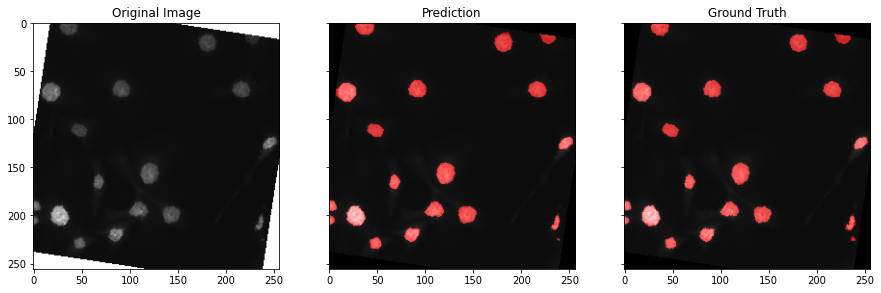

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


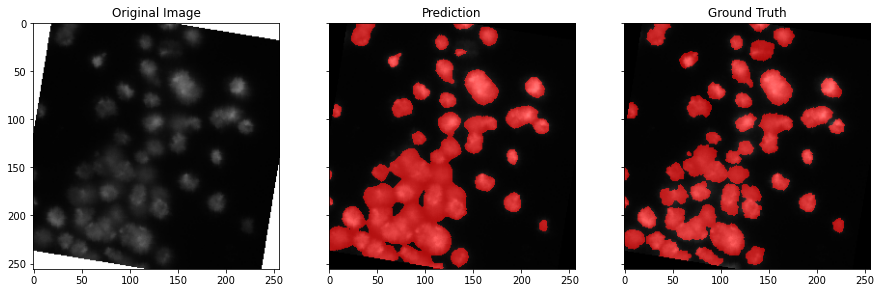

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


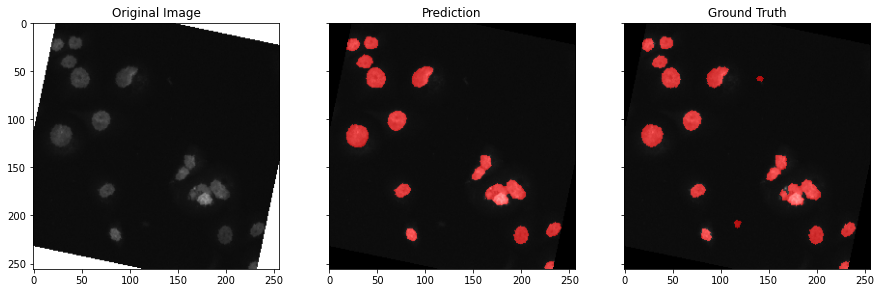

In [ ]:
predicted = []
with torch.no_grad():
  model.eval()
  for batch in test2_loader:
    image, true_seg = batch
    image, true_seg = image.to(torch.float32).to(device), true_seg.to(torch.float32).to(device)
    predicted.extend(unet(image))

    for i in range(3):
      img = image[i].permute((1, 2, 0)).cpu()
      true = true_seg[i].squeeze().cpu()
      pred = predicted[i].squeeze().cpu()
      plot_seg(img.numpy(), pred.numpy(), true.numpy())
    
    break